In [104]:
%pylab inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'CMRmap'
rcParams['figure.facecolor'] = 'w'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


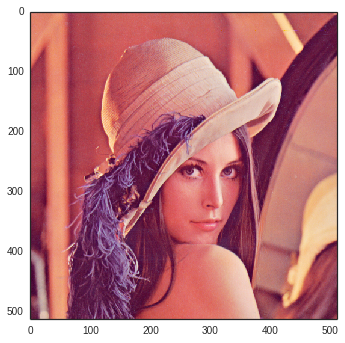

In [105]:
from skimage import data
lena = data.lena()
imshow(lena)

### RGB <-> YUV tools

In [70]:
# From: https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion
RGB_TO_YUV = np.array([
    [ 0.299,     0.587,     0.114],
    [-0.168736, -0.331264,  0.5],
    [ 0.5,      -0.418688, -0.081312]])
YUV_TO_RGB = np.array([
    [1.0,  0.0,      1.402],
    [1.0, -0.34414, -0.71414],
    [1.0,  1.772,    0.0]])
YUV_OFFSET = np.array([0, 128.0, 128.0]).reshape(1, 1, -1)

def rgb2yuv(im):
    return (np.tensordot(im, RGB_TO_YCBCR, ([2], [1])) + YCBCR_OFFSET)

def yuv2rgb(im):
    return np.tensordot(im.astype(float) - YCBCR_OFFSET, YCBCR_TO_RGB, ([2], [1]))

Now we need to build up the bilateral grid.

For each pixel (x, y) in the image we need to find the index of the appropriate pixel in  (x, y, l, u, v). 

In [84]:
MAX_VAL = 255.0
from scipy.sparse import csr_matrix

def get_valid_idx(valid, candidates):
    """Find which values are present in a list and where they are located"""
    locs = np.searchsorted(valid, candidates)
    # Handle edge case where the candidate is larger than all valid values
    locs = np.clip(locs, 0, len(valid) - 1)
    # Identify which values are actually present
    valid_idx = np.flatnonzero(valid[locs] == candidates)
    locs = locs[valid_idx] 
    return valid_idx, locs

class BilateralGrid(object):
    def __init__(self, im, sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        im_yuv = rgb2yuv(im)
        # Compute 5-dimensional XYLUV bilateral-space coordinates
        Iy, Ix = np.mgrid[:im.shape[0], :im.shape[1]]
        x_coords = (Ix / sigma_spatial).astype(int)
        y_coords = (Iy / sigma_spatial).astype(int)
        luma_coords = (im_yuv[..., 0] /sigma_luma).astype(int)
        chroma_coords = (im_yuv[..., 1:] / sigma_chroma).astype(int)
        coords = np.dstack((x_coords, y_coords, luma_coords, chroma_coords))
        coords_flat = coords.reshape(-1, coords.shape[-1])
        self.npixels, self.dim = coords_flat.shape
        # Hacky "hash vector" for coordinates.
        self.hash_vec = (MAX_VAL**np.arange(self.dim))
        # Construct S and B matrix
        self._compute_factorization(coords_flat)
        
    def _compute_factorization(self, coords_flat):
        # Hash each coordinate in grid to a unique value
        hashed_coords = self._hash_coords(coords_flat)
        unique_hashes, unique_idx, idx = \
            np.unique(hashed_coords, return_index=True, return_inverse=True) 
        # Identify unique set of vertices
        unique_coords = coords_flat[unique_idx]
        self.nvertices = len(unique_coords)
        # Construct sparse splat matrix that maps from pixels to vertices
        self.S = csr_matrix((np.ones(self.npixels), (idx, np.arange(self.npixels))))
        # Construct sparse blur matrices.
        # Note that these represent [1 0 1] blurs, excluding the central element
        self.blurs = []
        for d in xrange(self.dim):
            blur = 0.0
            for offset in (-1, 1):
                offset_vec = np.zeros((1, self.dim))
                offset_vec[:, d] = offset
                neighbor_hash = self._hash_coords(unique_coords + offset_vec)
                valid_coord, idx = get_valid_idx(unique_hashes, neighbor_hash)
                blur = blur + csr_matrix((np.ones((len(valid_coord),)),
                                          (valid_coord, idx)),
                                         shape=(self.nvertices, self.nvertices))
            self.blurs.append(blur)
        
    def _hash_coords(self, coord):
        """Hacky function to turn a coordinate into a unique value"""
        return np.dot(coord.reshape(-1, self.dim), self.hash_vec)

    def splat(self, x):
        return self.S.dot(x)
    
    def slice(self, y):
        return self.S.T.dot(y)
    
    def blur(self, x):
        """Blur a bilateral-space vector with a 1 2 1 kernel in each dimension"""
        assert x.shape[0] == self.nvertices
        out = 2 * self.dim * x
        for blur in self.blurs:
            out += blur.dot(x)
        return out

    def filter(self, x):
        """Apply bilateral filter to an input x"""
        return self.slice(self.blur(self.splat(x))) /  \
               self.slice(self.blur(self.splat(np.ones_like(x))))

In [85]:
im = lena.copy()
grid_params = {
    'sigma_luma' : 8,
    'sigma_chroma': 8,
    'sigma_spatial': 32
}

In [86]:
%%time
grid = BilateralGrid(im, **grid_params)

CPU times: user 80.3 ms, sys: 247 ms, total: 327 ms
Wall time: 76.2 ms


In [89]:
x = im[..., 0].reshape(-1, 1)


In [90]:
x.dtype

dtype('uint8')

In [99]:
%%time
im_shape = im.shape[:2]
x = im[..., 0].reshape(-1, 1) / 255.0
xnoise = x + 0.1 * np.random.randn(*x.shape)
y = grid.filter(xnoise)

CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 17 ms


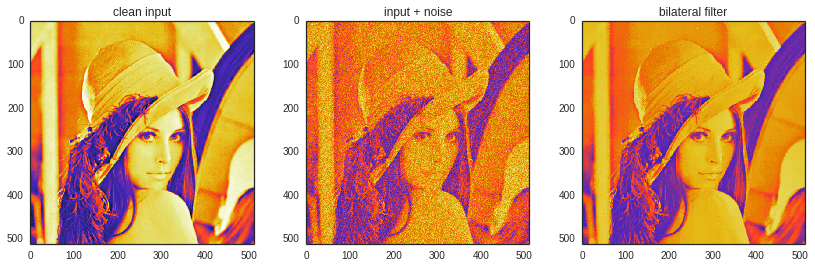

In [110]:
figure(figsize=(14, 4))
subplot(131)
imshow(x.reshape(im_shape))
title('clean input')
subplot(132)
imshow(xnoise.reshape(im_shape))
title('input + noise')
subplot(133)
imshow(y.reshape(im_shape))
title('bilateral filter')